In [1]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from glob import glob
from uuid import uuid4
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
startech_df = pd.concat(
    [pd.read_excel(path) for path in glob("./datasets/scrapped_data/*")]
)
print(startech_df.shape)
startech_df = startech_df.dropna().reset_index(drop=True).copy()
startech_df["id"] = [str(uuid4()) for _ in range(startech_df.shape[0])]
startech_df = startech_df[["id", "name", "price", "category", "specification"]]
print(startech_df.shape)
startech_df.head(5)

(7913, 4)
(6334, 5)


,id,name,price,category,specification
0,f13675a6-8502-410b-80dd-f591ff1bedc8,AMD Ryzen 5 5600G Budget Desktop PC,26699,Star PC,Processor: AMD Ryzen 5 5600G Processor with Ra...
1,959a8c24-ead8-46d5-9934-09602ee708e2,AMD Ryzen 5 5600G Desktop PC,29500,Star PC,Processor: AMD Ryzen 5 5600G Processor with Ra...
2,7f6d2a8f-c6ef-4207-b817-c4e0c3df93a0,Intel 12th Gen Core i5-12400 Desktop PC,31200,Star PC,Processor: Intel 12th Gen Core i5-12400 Alder ...
3,b9d5b6f7-d8f1-4262-a1fe-f787fd37f631,AMD Ryzen 7 5700G Custom Desktop PC,32400,Star PC,Processor: AMD Ryzen 7 5700G Processor with Ra...
4,58528ec5-3165-460e-a6b9-a50a31207c7b,AMD Ryzen 5 8500G Desktop PC,37499,Star PC,Processor: AMD Ryzen 5 8500G Processor with Ra...


In [ ]:
startech_df_first_half = (
    startech_df.iloc[0 : startech_df.shape[0] // 2].reset_index(drop=True).copy()
)
startech_df_last_half = (
    startech_df.iloc[startech_df.shape[0] // 2 :].reset_index(drop=True).copy()
)

startech_df.to_excel("./datasets/startech.xlsx", index=False, engine="xlsxwriter")
startech_df_first_half.to_excel(
    "./startech_first_half.xlsx", index=False, engine="xlsxwriter"
)
startech_df_last_half.to_excel(
    "./startech_last_half.xlsx", index=False, engine="xlsxwriter"
)

## Join generated queries dataframe with main dataset


In [2]:
def format_product_details(name, price, specification):
    product_details = ""
    if specification is not None:
        product_details = f"Name: {name}\nPrice: {price} taka\n{specification.strip()}"
    else:
        product_details = f"Name: {name}\nPrice: {price} taka"

    return product_details

In [6]:
query_df = [pd.read_excel(path) for path in glob("./datasets/generated_data/english/*.xlsx")]
query_df.extend([pd.read_excel(path) for path in glob("./datasets/generated_data/bengali/*.xlsx")])

query_df = pd.concat(query_df)
print(query_df.shape)
query_df.sample(10).head(10)

(89078, 2)


,id,relevant_query
391,ea5cc9ec-b163-455a-aa7e-884cf9ea326e,slim laptop keys
1021,ff991958-c107-4f6e-b1ac-f65bd371745a,long lasting bluetooth audio
3385,2bb8a7ee-f154-4099-8c3b-8645b62ee6ad,Dahua SD49225DB-HNY camera specifications
6628,a3718350-5632-40fb-9573-d578249efab1,MiPhi MP700G4 SSD কিনলে কেমন হবে?
8338,fb24d98a-c87a-4bf9-91cb-873cfbce642e,ভালো মানের ক্যামেরা লেন্স দরকার
5227,ac195b47-8255-4b56-962f-914ddbb436f8,M10 হ্যান্ডহেল্ড প্রিন্টার রিভিউ
224,db4cceeb-101f-4062-b239-5060de8f9d16,large screen 4k smart tv
29659,b3cd7adb-d792-44fb-a950-93283f33d464,নতুন গান শোনার জন্য হেডফোন
30672,d5b6bba2-f1a0-4978-9e4b-9162eaa48bbe,মোবাইল দিয়ে ভিডিও শুট করার জন্য স্ট্যাবিলাইজার
25464,82310159-9045-4e53-afd8-891a89a7acb7,স্টুডিও রেকর্ডিং এর জন্য মাইক্রোফোন


In [4]:
product_df = pd.read_excel("./datasets/startech.xlsx")
print(product_df.shape)
product_df.head(5)

(6334, 5)


,id,name,price,category,specification
0,ff9f4b9c-64f8-4b20-8cbb-698db1302f05,AMD Ryzen 5 5600G Budget Desktop PC,26699,Star PC,Processor: AMD Ryzen 5 5600G Processor with Ra...
1,34c772a6-ef7d-4f3c-ae95-3c8acff1a1b4,AMD Ryzen 5 5600G Desktop PC,29500,Star PC,Processor: AMD Ryzen 5 5600G Processor with Ra...
2,e3c3d67a-5138-481b-930c-dcb64ea67b93,Intel 12th Gen Core i5-12400 Desktop PC,31200,Star PC,Processor: Intel 12th Gen Core i5-12400 Alder ...
3,797a3b0a-8c2b-4cf6-8a90-2f36a82bd722,AMD Ryzen 7 5700G Custom Desktop PC,32400,Star PC,Processor: AMD Ryzen 7 5700G Processor with Ra...
4,71be6c35-b744-4b69-8f1b-ee665c29a76a,AMD Ryzen 5 8500G Desktop PC,37499,Star PC,Processor: AMD Ryzen 5 8500G Processor with Ra...


## Adding category to query dataframe


In [7]:
query_df = query_df.merge(product_df[["id", "category"]], on="id", how="left").copy()
print(query_df.shape)
query_df.tail(10)

(89078, 3)


,id,relevant_query,category
89068,56c303df-c2f8-4121-a7be-c4eacff2069e,পেশাদার কাপড় গরম করার যন্ত্র,Iron
89069,56c303df-c2f8-4121-a7be-c4eacff2069e,Panasonic NI-GSE040PTH মডেলের কাপড় গরম করার যন...,Iron
89070,56c303df-c2f8-4121-a7be-c4eacff2069e,Panasonic NI-GSE040PTH দিয়ে সহজে কাপড় গরম করা ...,Iron
89071,a00a4134-03d9-462c-bd4e-c947f61cf40b,কাপড় পরিষ্কার করার যন্ত্র,Iron
89072,a00a4134-03d9-462c-bd4e-c947f61cf40b,স্টিম দিয়ে কাপড় ফর্সা করার মেশিন,Iron
89073,a00a4134-03d9-462c-bd4e-c947f61cf40b,গাড়ামালির জন্য বাষ্পীভবনকারী,Iron
89074,a00a4134-03d9-462c-bd4e-c947f61cf40b,নতুন কাপড় ভাঁজ করার সরঞ্জাম,Iron
89075,a00a4134-03d9-462c-bd4e-c947f61cf40b,গাড়ামালির জন্য বাষ্পীভবনকারী,Iron
89076,a00a4134-03d9-462c-bd4e-c947f61cf40b,Panasonic NI-GSE050ATH মডেলের স্টিমার,Iron
89077,a00a4134-03d9-462c-bd4e-c947f61cf40b,Panasonic গাড়ামালির জন্য স্টিমার,Iron


## For every product of a category, take positive query from other categories


In [14]:
category_list = list(product_df["category"].unique())
print(f"Num categories: {len(category_list)}")

train_dict = {"category": [], "anchor": [], "positive": [], "negative": []}

for idx, row in tqdm(product_df.iterrows(), total=product_df.shape[0]):
    id = row["id"]
    name = row["name"]
    price = row["price"]
    specification = row["specification"]
    category = row["category"]

    anchor = format_product_details(name, price, specification)

    positive_queries = query_df[query_df["id"] == id]["relevant_query"].tolist() + [name]
    num_positive_queries = len(positive_queries)

    # take num_positive_queries random categories except current category
    random_categories = np.random.choice(
        product_df[product_df["category"] != category]["category"].unique().tolist(),
        num_positive_queries,
        replace=False,
    )

    for random_category in random_categories:
        random_query = np.random.choice(
            list(query_df[query_df["category"] == random_category]["relevant_query"]),
            1,
            replace=False,
        )[0]
        train_dict["negative"].append(str(random_query))

    train_dict["category"].extend([category] * num_positive_queries)
    train_dict["anchor"].extend([anchor] * num_positive_queries)
    train_dict["positive"].extend(positive_queries)

Num categories: 166


  0%|          | 0/6334 [00:00<?, ?it/s]

In [37]:
all_data = pd.DataFrame.from_dict(train_dict)
all_data.sample(10).head(10)

,category,anchor,positive,negative
94957,Blender,Name: Xiaomi MIJIA MJZZB01PL 300ml Portable Ju...,compact fruit and vegetable juicer,network switch for small business
54811,Server Rack,Name: Cote 6U 600 x 600mm Server Rack\nPrice: ...,server rack 19 inch,কাগজ কুচি করার যন্ত্র
6343,Motherboard,Name: GIGABYTE H510M K Intel Micro ATX Motherb...,GIGABYTE H510M K Intel Micro ATX Motherboard,Xprinter XP-TT424B specifications
55931,Keyboard,Name: Redragon K509 DYAUS 7 Colors Backlit Gam...,ergonomic low profile keyboard,compact gaming laptop for mobile gaming
13265,SSD,Name: HP EX900 M.2 250GB PCIe NVMe Internal SS...,নতুন হার্ডডিস্কের সন্ধান,Fiber optic network adapter
68574,Mouse,Name: WiWU WM108 Dual Mode Wireless Mouse\nPri...,WiWU WM108 dual mode mouse,DJI Mini 3 উড়োজাহাজ
9724,RAM (Desktop),Name: TEAM T-FORCE DELTA RGB 8GB 6000MHz DDR5 ...,গেমিং এর জন্য দ্রুত র‍্যাম,কর্মকর্তা কার্ড তৈরির মেশিন
77364,Microphone,Name: Rapoo VS500 Dual Point Omni Directional ...,RGB লাইট সহ মাইক্রোফোন,নতুন গেমিং কার্ড খুঁজছি
92976,AC,Name: General 2 Ton Inverter AC\nPrice: 114834...,quiet home cooling system,external hard drive enclosure 5 bay
63017,Laptop Accessories,Name: Laptop Battery For Asus C31N1428\nPrice:...,asus ল্যাপটপের জন্য নতুন ব্যাটারি,Sony Bravia XR 65A80K TV review


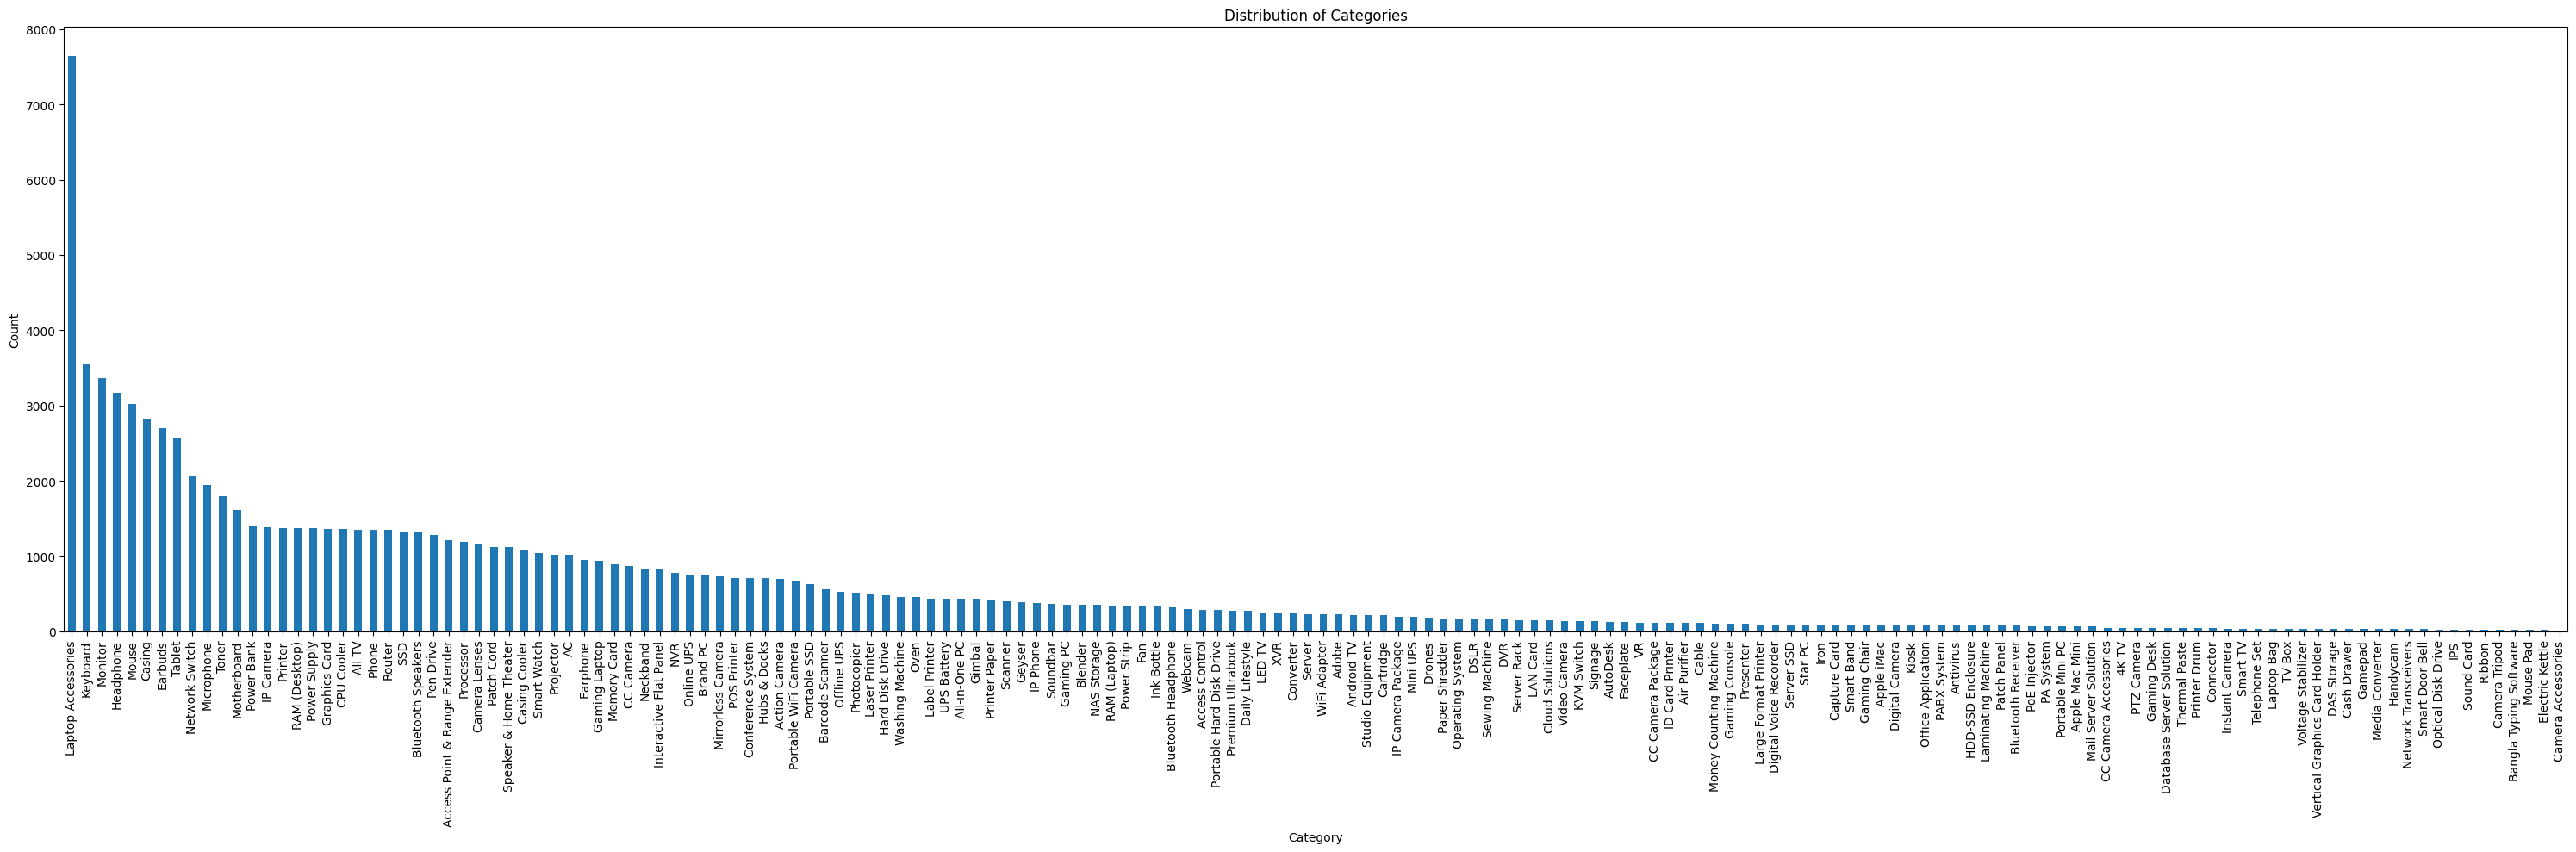

In [38]:
plt.figure(figsize=(30, 10))
all_data["category"].value_counts().plot(kind="bar")
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Distribution of Categories")
plt.tight_layout()
plt.show()

## Dataset split


In [39]:
train_df, val_df = train_test_split(
    all_data,
    test_size=0.10,
    random_state=42,
    stratify=all_data["category"],
    shuffle=True,
)
train_df, test_df = train_test_split(
    train_df,
    test_size=0.20,
    random_state=42,
    stratify=train_df["category"],
    shuffle=True,
)

train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)
val_df.reset_index(inplace=True, drop=True)

train_df.shape, val_df.shape, test_df.shape

((68696, 4), (9542, 4), (17174, 4))

In [40]:
train_df.to_csv("./datasets/train.csv", index=False)
test_df.to_csv("./datasets/test.csv", index=False)
val_df.to_csv("./datasets/val.csv", index=False)